# SVM Classification of MNIST Digits 
## CS156 Assignment 8


Load the entire MNIST digit dataset: http://yann.lecun.com/exdb/mnist/. 
Choose two digit classes (I'm choosing 4 and 8) from the training data, and plot some of the examples.



### Data Import and Prep

In [20]:
import numpy as np
import pandas as pd
import matplotlib as plt
import mnist
import scipy.misc
from sklearn.model_selection import cross_val_score
%matplotlib inline


In [3]:
""" I'm using the MNIST python library, which proved to be a much more convenient and tidy way. """

# Loading train images
X_train_img = mnist.train_images()
y_train_label = mnist.train_labels()
# Loading Test images
X_test_img = mnist.test_images()
y_test_label = mnist.test_labels()

In [4]:
""" Choosing digits 4 & 8, Slicing the dataset to only those """
# np.where gives the indexes of where the query is correct; 
# i'm querying where the labels are 4 or 8

# creating a list of locations of chosen digits. This location is valid for both X and Y
chosen_locs_train = np.where(np.logical_or(y_train_label == 4 , y_train_label == 8 ))
X_train = X_train_img[chosen_locs_train] #Slicing Training Set 
y_train = y_train_label[chosen_locs_train] #Slicing Test Set

chosen_locs_test = np.where(np.logical_or(y_test_label == 4 , y_test_label == 8 ))
X_test = X_test_img[chosen_locs_test]
y_test = y_test_label[chosen_locs_test]



In [6]:
# data length verification
print "length of training and test images arrays:", len(X_train), "," ,len(y_train)
print "length of training and test labels arrays:", len(X_test), "," ,len(y_test)
print "Test set proportion: ", float(len(X_test))/(len(X_train)+len(X_test))

length of training and test images arrays: 11693 , 11693
length of training and test labels arrays: 1956 , 1956
Test set proportion:  0.143307201993


labeled:  4


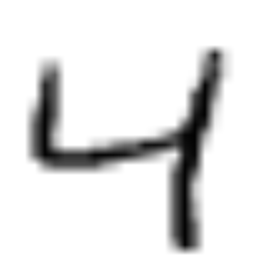

In [7]:
""" plotting examples as images """
def print_digit(i):
    print "labeled: ", y_train[i]
    return scipy.misc.toimage(scipy.misc.imresize(X_train[i,:,:] * -1 + 256, 10.))

print_digit(0)

labeled:  4


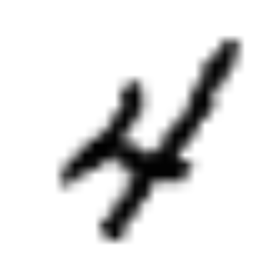

In [6]:
print_digit(1)

labeled:  4


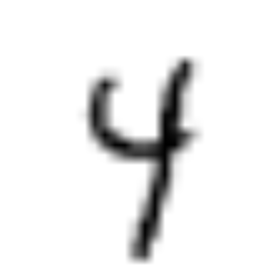

In [7]:
print_digit(4)

labeled:  8


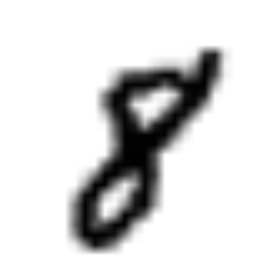

In [8]:
print_digit(2)

labeled:  8


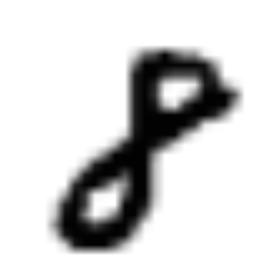

In [9]:
print_digit(5)

In [10]:
# Standartize data: 
# Rescale pixel grayness scale instead from 0-255, to from -1 to 1
X_train_std = X_train/255.0*2 - 1


## Modeling SVC
Train a support vector classifier using each of the following kernels:
1. Linear
2. Poly
3. RBF
(If you encounter any issues with training time or memory issues, then you may use a reduced dataset, but carefully detail how you reduced the dataset.)

Report your *training times* on the dataset for the different kernels.
Report your *error rates on the testing dataset* for the different kernels.

In [8]:
""" Imports and preperations for modeling with SVC"""
from sklearn import svm
import time
from sklearn.metrics import accuracy_score, classification_report


# To apply a classifier on this data, we need to flatten the image, 
# to turn the data in a (samples, feature) matrix: (as learned from http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)
def flatten(data):
    n_samples = len(data)
    return data.reshape((n_samples, -1))

X_train = flatten(X_train)
X_test = flatten(X_test)


### Creating a function which will train SVC and report results

In [74]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
performances_cv = []

def predict_svc(kernel_type,C=1, gamma=None,degree=None):
    """ Function for training an SVC model and reporting results
        Printing detailed results to console and adding key metrics summary to a list"""
    from sklearn.metrics import accuracy_score, classification_report
    from sklearn import svm
    import time
    print("kernel_type: {}".format(kernel_type))
    if kernel_type != 'linear':
        print("Parameters are: gamma={}, degree={}".format(gamma,degree) )

    """Training the model using cross validation"""
    start_time = time.time()
    C = C  # SVM regularization parameter
    if kernel_type == 'linear':
        clf = svm.SVC(kernel=kernel_type, C=C) 
    if kernel_type == 'rbf':
        clf = svm.SVC(kernel=kernel_type, C=C, gamma=gamma)
    if kernel_type == 'poly':
        clf = svm.SVC(kernel=kernel_type, C=C, degree=degree)
    clf.fit(X_train,y_train) #train on training set
    training_time = time.time() - start_time  #measuring training time
    print("Training time: {}".format(training_time))
    # Predict using that SVC model on the test set
    
    """Cross Validating the Model"""
    cv_results = cross_validate(clf, X_train, y_train,
                            cv=3, return_train_score=True)
    
    # averaging each CV result, making into a list
    mean_cv_results = [np.mean(result) for result in cv_results.values()]   #averaging cv results

    """ Testing final model on the test set"""
    # Report performance and error rate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    error_rate = 1-accuracy
    print("Got {} digits wrong out of {}".format(len(y_test)-accuracy_score(y_test,y_pred,normalize=False),len(y_test)))
    print("Accuracy Score (fraction correctly predicted): {}").format(accuracy)
    print("Error Rate): {}").format(error_rate)
    print(classification_report(y_test,y_pred))
    print ("________________________")
    
    """ Add results together to a table"""
    
    #test_cols = ['Kernel_Type','Final_Training_time', 'Final_Test_Error_rate', 'Gamma (for RBF)','Degree (for Poly)']
    #cv_cols = ['CV_'+col for col in cv_results.keys()] #add CV to names of columns of Cross Validation results
    #cols = test_cols + cv_cols
    results = [kernel_type,C,training_time, error_rate, gamma, degree] + mean_results
    pd.DataFrame([results] , columns = cols)
    #pd.DataFrame(performances[-1], columns = ['Kernel_Type','Training_time', 'Error_rate', 'Gamma (for RBF)','Degree (for Poly)','cv_results'])

    # append performances into list
    performances_cv.append(results)
    
    return performances, results

## extracated the columns list resulting from the code
cols = ['Kernel_Type','C',
 'Final_Training_time',
 'Final_Test_Error_rate',
 'Gamma (for RBF)',
 'Degree (for Poly)',
 'CV_score_time',
 'CV_test_score',
 'CV_train_score',
 'CV_fit_time']

###  Linear Kernel

In [79]:
""" Linear Kernel"""
C_range = [0.1, 1, 10]
results_linear = []
for C in C_range:
    performances_cv, results = predict_svc('linear', C=C) 
    results_linear.append(results)

performances_cv
pd.DataFrame(results_linear , columns = cols)


kernel_type: linear
Training time: 6.37001991272
Got 17 digits wrong out of 1956
Accuracy Score (fraction correctly predicted): 0.991308793456
Error Rate): 0.00869120654397
             precision    recall  f1-score   support

          4       0.99      1.00      0.99       982
          8       1.00      0.99      0.99       974

avg / total       0.99      0.99      0.99      1956

________________________
kernel_type: linear
Training time: 4.93984699249
Got 17 digits wrong out of 1956
Accuracy Score (fraction correctly predicted): 0.991308793456
Error Rate): 0.00869120654397
             precision    recall  f1-score   support

          4       0.99      1.00      0.99       982
          8       1.00      0.99      0.99       974

avg / total       0.99      0.99      0.99      1956

________________________
kernel_type: linear
Training time: 5.50546193123
Got 17 digits wrong out of 1956
Accuracy Score (fraction correctly predicted): 0.991308793456
Error Rate): 0.00869120654397
 

,Kernel_Type,C,Final_Training_time,Final_Test_Error_rate,Gamma (for RBF),Degree (for Poly),CV_score_time,CV_test_score,CV_train_score,CV_fit_time
0,linear,100,5.57022,0.008691,None,None,0.645713,0.989566,1.0,2.404776


In [81]:
pd.DataFrame(results_linear , columns = cols)

,Kernel_Type,C,Final_Training_time,Final_Test_Error_rate,Gamma (for RBF),Degree (for Poly),CV_score_time,CV_test_score,CV_train_score,CV_fit_time
0,linear,0.01,6.370020,0.008691,None,None,0.645713,0.989566,1.0,2.404776
1,linear,0.10,4.939847,0.008691,None,None,0.645713,0.989566,1.0,2.404776
2,linear,1.00,5.505462,0.008691,None,None,0.645713,0.989566,1.0,2.404776
3,linear,10.00,6.488721,0.008691,None,None,0.645713,0.989566,1.0,2.404776
4,linear,100.00,5.570220,0.008691,None,None,0.645713,0.989566,1.0,2.404776


### Polynomial Kernel

In [82]:
degrees = [2,3,4,5,7,15,50]
results_polys = []
for degree in degrees:
    for C in [0.01,1,10]:
        performances_cv, results = predict_svc('poly', C=C, degree = degree) 
        results_polys.append(results)

# Showing a table of all poly results from Cross Validation and Tests
pd.DataFrame(results_polys , columns = cols)    

kernel_type: poly
Parameters are: gamma=None, degree=2
Training time: 5.89439821243
Got 3 digits wrong out of 1956
Accuracy Score (fraction correctly predicted): 0.998466257669
Error Rate): 0.00153374233129
             precision    recall  f1-score   support

          4       1.00      1.00      1.00       982
          8       1.00      1.00      1.00       974

avg / total       1.00      1.00      1.00      1956

________________________
kernel_type: poly
Parameters are: gamma=None, degree=2
Training time: 5.45201897621
Got 3 digits wrong out of 1956
Accuracy Score (fraction correctly predicted): 0.998466257669
Error Rate): 0.00153374233129
             precision    recall  f1-score   support

          4       1.00      1.00      1.00       982
          8       1.00      1.00      1.00       974

avg / total       1.00      1.00      1.00      1956

________________________
kernel_type: poly
Parameters are: gamma=None, degree=2
Training time: 6.46098804474
Got 3 digits wrong out

,Kernel_Type,C,Final_Training_time,Final_Test_Error_rate,Gamma (for RBF),Degree (for Poly),CV_score_time,CV_test_score,CV_train_score,CV_fit_time
0,poly,0.01,5.894398,0.001534,None,2,0.645713,0.989566,1.0,2.404776
1,poly,1.00,5.452019,0.001534,None,2,0.645713,0.989566,1.0,2.404776
2,poly,10.00,6.460988,0.001534,None,2,0.645713,0.989566,1.0,2.404776
3,poly,0.01,7.296155,0.002556,None,3,0.645713,0.989566,1.0,2.404776
4,poly,1.00,7.242651,0.002556,None,3,0.645713,0.989566,1.0,2.404776
5,poly,10.00,5.681775,0.002556,None,3,0.645713,0.989566,1.0,2.404776
6,poly,0.01,6.519933,0.004090,None,4,0.645713,0.989566,1.0,2.404776
7,poly,1.00,6.586887,0.004090,None,4,0.645713,0.989566,1.0,2.404776
8,poly,10.00,6.564051,0.004090,None,4,0.645713,0.989566,1.0,2.404776
9,poly,0.01,7.135663,0.005624,None,5,0.645713,0.989566,1.0,2.404776


### RBF Kernel

In [83]:
""" RBF KERNEL """
results_rbfs = []
for gamma in [0.001,0.1,1,10,100,'auto']:
    for C in [0.01,1,10]:
        performances_cv, results =  predict_svc('rbf',C=C,gamma=gamma) 
        results_rbfs.append(results)

pd.DataFrame(results_rbfs, columns = cols)

kernel_type: rbf
Parameters are: gamma=0.001, degree=None
Training time: 124.099403143
Got 982 digits wrong out of 1956
Accuracy Score (fraction correctly predicted): 0.497955010225
Error Rate): 0.502044989775
             precision    recall  f1-score   support

          4       0.00      0.00      0.00       982
          8       0.50      1.00      0.66       974

avg / total       0.25      0.50      0.33      1956

________________________
kernel_type: rbf
Parameters are: gamma=0.001, degree=None
Training time: 196.359272003
Got 982 digits wrong out of 1956
Accuracy Score (fraction correctly predicted): 0.497955010225
Error Rate): 0.502044989775
             precision    recall  f1-score   support

          4       0.00      0.00      0.00       982
          8       0.50      1.00      0.66       974

avg / total       0.25      0.50      0.33      1956

________________________
kernel_type: rbf
Parameters are: gamma=0.001, degree=None
Training time: 267.885152817
Got 982 digit

KeyboardInterrupt: 

In [88]:
pd.DataFrame(results_rbfs, columns = cols)

,Kernel_Type,C,Final_Training_time,Final_Test_Error_rate,Gamma (for RBF),Degree (for Poly),CV_score_time,CV_test_score,CV_train_score,CV_fit_time
0,rbf,0.01,124.099403,0.502045,0.001,None,0.645713,0.989566,1.0,2.404776
1,rbf,1.00,196.359272,0.502045,0.001,None,0.645713,0.989566,1.0,2.404776
2,rbf,10.00,267.885153,0.502045,0.001,None,0.645713,0.989566,1.0,2.404776
3,rbf,0.01,122.666485,0.502045,0.100,None,0.645713,0.989566,1.0,2.404776
4,rbf,1.00,303.459219,0.502045,0.100,None,0.645713,0.989566,1.0,2.404776
5,rbf,10.00,290.192518,0.502045,0.100,None,0.645713,0.989566,1.0,2.404776
6,rbf,0.01,139.801483,0.502045,1.000,None,0.645713,0.989566,1.0,2.404776
7,rbf,1.00,217.878438,0.502045,1.000,None,0.645713,0.989566,1.0,2.404776
8,rbf,10.00,299.449037,0.502045,1.000,None,0.645713,0.989566,1.0,2.404776


## All Modles Results


In [91]:
## All Modles Results
pd.DataFrame(results_linear + results_polys + results_rbfs, columns = cols)

,Kernel_Type,C,Final_Training_time,Final_Test_Error_rate,Gamma (for RBF),Degree (for Poly),CV_score_time,CV_test_score,CV_train_score,CV_fit_time
0,linear,0.01,6.370020,0.008691,NaN,NaN,0.645713,0.989566,1.0,2.404776
1,linear,0.10,4.939847,0.008691,NaN,NaN,0.645713,0.989566,1.0,2.404776
2,linear,1.00,5.505462,0.008691,NaN,NaN,0.645713,0.989566,1.0,2.404776
3,linear,10.00,6.488721,0.008691,NaN,NaN,0.645713,0.989566,1.0,2.404776
4,linear,100.00,5.570220,0.008691,NaN,NaN,0.645713,0.989566,1.0,2.404776
5,poly,0.01,5.894398,0.001534,NaN,2.0,0.645713,0.989566,1.0,2.404776
6,poly,1.00,5.452019,0.001534,NaN,2.0,0.645713,0.989566,1.0,2.404776
7,poly,10.00,6.460988,0.001534,NaN,2.0,0.645713,0.989566,1.0,2.404776
8,poly,0.01,7.296155,0.002556,NaN,3.0,0.645713,0.989566,1.0,2.404776
9,poly,1.00,7.242651,0.002556,NaN,3.0,0.645713,0.989566,1.0,2.404776


## Results

The results table shows clearly that in this case, the Polynomial Kernel with a low higher degree outperforms the others (2 was the best, even up to 5 was relatively better than other model types), having the lowest error rate (0.001) and similarly short training time as the Linear Kernel (5-6 seconds vs ~3-6 minutes minimum for the RBF). 

The Polynomial Kernels showed that the best performance was with only a 2nd heigher degree polynomial; and accuracy declined from there, until being absurdly bad with above 15 degrees, weirdly remaining exactly the same between 15,20, or 50 polynomial degrees.
Overfitting the training set is a probably culprit, as the higher the degree, the more it might overfit. Our data is probably simple enough to represent well with a second degree polynomial (or even with just the first degree / linear...), so that maybe above ~10 degrees there was really no more room for improvement of fit.

The RBF performs surprisingly poorly, both in terms of accuracy (0.5!) and time (~x40 times slower than the linear or polynomial!). The Kernel paramters didn't seem to matter much for the RBF; it probably was just equally as bad. I tried to debug it but found no bugs there; I suspect it might just be hitting its limit of incorrect classification every time.

Additionally, the Cross-Validation results might be off since they seem uniform across the board; I also tried to debug that but didn't find where is the bug on time at least.

This shows that this is probably a simple enough task and dataset such that RBF might overcomplicate or learn irrelevant dimensions, and a simpler linear or polynomial kernels suffice. 
This shows us that the more complex the model is, not necessarily the better, but it can actually be worse! So it's worth it to try various directions for the parameters before choosing.